# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW01] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from collections import namedtuple
from typing import NoReturn, Tuple, List
import time

cancer_dataset_path = '../../src/hw1/data/cancer.csv'
spam_dataset_path = '../../src/hw1/data/spam.csv'

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [2]:
def scale_std(X):
    X_prep = X.copy()
    col_mean = np.mean(X_prep, axis=0)
    col_std = np.std(X_prep, axis=0)
    X_prep = (X_prep - col_mean) / col_std
    return X_prep


def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """

    Parameters
    ----------
    path_to_csv : str
        Путь к cancer датасету.

    Returns
    -------
    X : np.array
        Матрица признаков опухолей.
    y : np.array
        Вектор бинарных меток, 1 соответствует злокачественной опухоли (M),
        0 --- доброкачественной (B).


    """
    data = pd.read_csv(path_to_csv)
    data = data.sample(frac=1).reset_index(drop=True)

    y = data['label']
    data.drop(['label'], axis=1, inplace=True)
    data_scaled = scale_std(data.to_numpy())

    y = y.map({
        'M': 1,
        'B': 0
    })

    return data_scaled, y.to_numpy()


def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """

    Parameters
    ----------
    path_to_csv : str
        Путь к spam датасету.

    Returns
    -------
    X : np.array
        Матрица признаков сообщений.
    y : np.array
        Вектор бинарных меток,
        1 если сообщение содержит спам, 0 если не содержит.

    """
    data = pd.read_csv(path_to_csv)
    data = data.sample(frac=1).reset_index(drop=True)

    y = data['label']
    data.drop(['label'], axis=1, inplace=True)
    data_scaled = scale_std(data.to_numpy())

    return data_scaled, y.to_numpy()

In [3]:
read_cancer_dataset(cancer_dataset_path)

(array([[-0.32584714,  0.0140442 , -0.30682718, ..., -0.24402485,
          1.12475273,  0.42748774],
        [-0.54737821, -0.94936159, -0.57497538, ..., -0.89907307,
         -0.38787214, -0.24027286],
        [-0.35424856,  2.24104744, -0.39003138, ..., -0.75639985,
         -0.85541074, -0.63871258],
        ...,
        [-0.76606915, -0.90747438, -0.77886687, ..., -0.45445642,
         -0.36360543, -0.90304603],
        [-1.24860926, -0.91910972, -1.16111193, ...,  0.64703563,
          0.33527579,  2.32492533],
        [ 1.27883307,  1.35443486,  1.35231409, ...,  1.06881238,
          0.87885008,  0.76884918]]),
 array([0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
   

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [4]:
def train_test_split(X: np.array, y: np.array, ratio: float) -> Tuple[np.array, np.array, np.array, np.array]:
    """

    Parameters
    ----------
    X : np.array
        Матрица признаков.
    y : np.array
        Вектор меток.
    ratio : float
        Коэффициент разделения.

    Returns
    -------
    X_train : np.array
        Матрица признаков для train выборки.
    y_train : np.array
        Вектор меток для train выборки.
    X_test : np.array
        Матрица признаков для test выборки.
    y_test : np.array
        Вектор меток для test выборки.

    """
    train_sz = int(X.shape[0] * ratio)

    X_train, X_test = X[:train_sz, :], X[train_sz:, :]
    y_train, y_test = y[:train_sz], y[train_sz:]

    return X_train, y_train, X_test, y_test

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [5]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array) -> Tuple[np.array, np.array, float]:
    """

    Parameters
    ----------
    y_pred : np.array
        Вектор классов, предсказанных моделью.
    y_true : np.array
        Вектор истинных классов.

    Returns
    -------
    precision : np.array
        Вектор с precision для каждого класса.
    recall : np.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).

    """
    accuracy = np.count_nonzero(y_true == y_pred) / len(y_true)

    classes = np.unique(y_true)
    precision_arr, recall_arr = [], []
    negative, positive = False, True

    for cl in classes:
        y_true_cl = y_true == cl
        y_pred_cl = y_pred == cl

        tp = np.count_nonzero(np.logical_and(y_pred_cl == positive, y_true_cl == positive))
        tn = np.count_nonzero(np.logical_and(y_pred_cl == negative, y_true_cl == negative))
        fp = np.count_nonzero(np.logical_and(y_pred_cl == positive, y_true_cl == negative))
        fn = np.count_nonzero(np.logical_and(y_pred_cl == negative, y_true_cl == positive))

        precision_arr.append(tp / (tp + fp))
        recall_arr.append(tp / (tp + fn))

    return np.array(precision_arr), np.array(recall_arr), accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [6]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [7]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [8]:
class KDTree:
    def __init__(self, X: np.array, leaf_size: int = 40):
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области,
            в которых не меньше leaf_size точек).

        Returns
        -------

        """

        self.leaf = namedtuple('leaf', ('node_type', 'points'))
        self.node = namedtuple('node', ('node_type', 'split_param_name', 'split_param_val', 'lnode', 'rnode'))
        ind = np.array([*range(X.shape[0])]).reshape((-1, 1))
        X = np.hstack([X, ind])

        self.root = self.build(X, leaf_size=leaf_size)

    def build(self, X: np.array, split_feature=0, leaf_size: int = 40):
        good_split = False
        for i in range(X.shape[1] - 1):
            split_feature %= X.shape[1] - 1

            arr = X[:, split_feature]
            median = np.median(arr)
            median_mask = X[:, split_feature] < median

            # Если убрали хотя бы 5%, то ок
            if len(np.nonzero(median_mask)[0]) / X.shape[0] > 0.05:
                good_split = True
                break
            split_feature += 1

        if not good_split:
            return self.leaf('leaf', X.copy())

        # Если не можем разделить, чтобы размер был хотя бы leaf_size, то лист
        if len(np.nonzero(median_mask)[0]) <= leaf_size:
            return self.leaf('leaf', X.copy())

        xl = X[median_mask]
        xr = X[~median_mask]

        lnode = self.build(xl, split_feature + 1, leaf_size)
        rnode = self.build(xr, split_feature + 1, leaf_size)

        return self.node('node', split_feature, median, lnode, rnode)

    def query(self, X: np.array, k: int = 1) -> List[List]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно найти ближайших соседей.
        k : int
            Число ближайших соседей.

        Returns
        -------
        list[list]
            Список списков (длина каждого списка k):
            индексы k ближайших соседей для всех точек из X.

        """
        res = []
        for x in X:
            res_x = self.query_one(x, k=k)
            res.append(res_x)
        return res


    def sort_by_dist(self, X, y):
        self.comparisons += X.shape[0]
        ind = X[:, -1].reshape((-1, 1))
        X = np.delete(X, obj=X.shape[1] - 1, axis=1)

        # a fast way to calc dist to all points
        dist_to_all_points = np.sum((X - y) ** 2, axis=1) ** (1 / 2)
        dist_to_all_points = dist_to_all_points.reshape((-1, 1))

        X_w_dists = np.hstack([X, dist_to_all_points, ind])
        X_w_dists = X_w_dists[X_w_dists[:, -2].argsort()]

        return X_w_dists

    def query_one(self, x: np.array, k=1):
        self.comparisons = 0
        res = self._query_one(x, node=self.root, k=k)
        return res[:, -1]

    def _query_one(self, x: np.array, node, k=1):
        if node.node_type == 'leaf':
            return self.sort_by_dist(node.points, x)[:k]

        node_order = [node.lnode, node.rnode]
        if x[node.split_param_name] > node.split_param_val:
            node_order.reverse()

        arr1 = self._query_one(x, node_order[0], k)
        # Мы не хотим брать индекс и расстояние до x у точки
        r = arr1[-1, -2]

        if r > abs(node.split_param_val - x[node.split_param_name]) or arr1.shape[0] < k:
            arr2 = self._query_one(x, node_order[1], k)
            return KDTree.merge(arr1, arr2, -2, k)
        else:
            return arr1

    @staticmethod
    def dist(x, y):
        return np.linalg.norm(x - y)
    
    @staticmethod
    def merge2(arr1, arr2, feature, k):
        arr = np.vstack([arr1, arr2])
        arr = arr[arr[:, feature].argsort()]
        return arr[:k]
        
    @staticmethod
    def merge(arr1, arr2, feature, k):
        res = []
        l, r = 0, 0
        for i in range(k):
            if l >= arr1.shape[0] and r < arr2.shape[0]:
                elem = arr2[r]
                r += 1
            elif l < arr1.shape[0] and r >= arr2.shape[0]:
                elem = arr1[l]
                l += 1
            elif l >= arr1.shape[0] and r >= arr2.shape[0]:
                break
            elif arr1[l][feature] < arr2[r][feature]:
                elem = arr1[l]
                l += 1
            else:
                elem = arr2[r]
                r += 1
            res.append(elem)
        return np.array(res, dtype="object")

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [9]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [10]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        """

        Parameters
        ----------
        n_neighbors : int
            Число соседей, по которым предсказывается класс.
        leaf_size : int
            Минимальный размер листа в KD-дереве.

        """
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size

    def fit(self, X: np.array, y: np.array) -> NoReturn:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которым строится классификатор.
        y : np.array
            Метки точек, по которым строится классификатор.

        """
        self.y = y.copy()
        start = time.time()
        self.kd_tree = KDTree(X, leaf_size=self.leaf_size)

    def predict_proba(self, X: np.array) -> List[np.array]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.

        Returns
        -------
        list[np.array]
            Список np.array (длина каждого np.array равна числу классов):
            вероятности классов для каждой точки X.


        """
        inds = self.kd_tree.query(X, self.n_neighbors)
        res = []
        y_max = np.max(self.y)
        for ind_arr in inds:
            cls = self.y[ind_arr.astype(int)]
            freq = np.bincount(cls)
            if len(freq) - 1 != y_max:
                prob = np.concatenate([freq, ([0] * (y_max - len(freq) + 1))])
            else:
                prob = freq
            prob = prob / np.sum(freq)
            res.append(prob)
        return res

    def predict(self, X: np.array) -> np.array:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.

        Returns
        -------
        np.array
            Вектор предсказанных классов.


        """
        res = np.argmax(self.predict_proba(X), axis=1)
        return res

Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

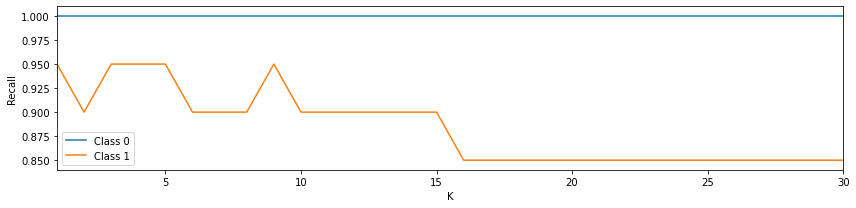

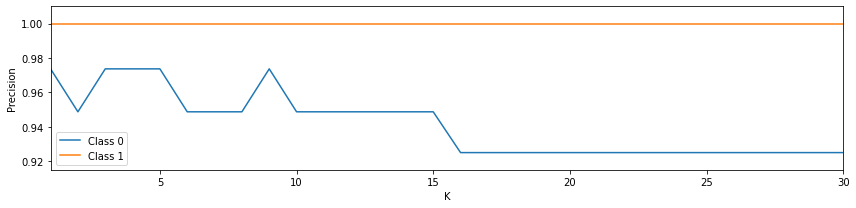

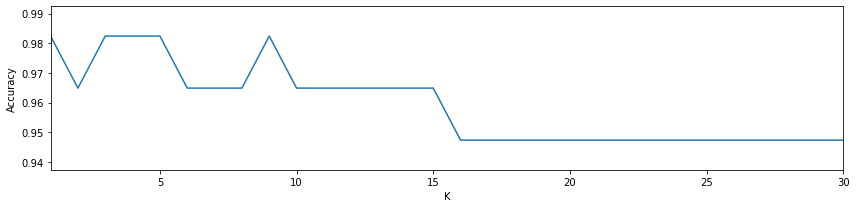

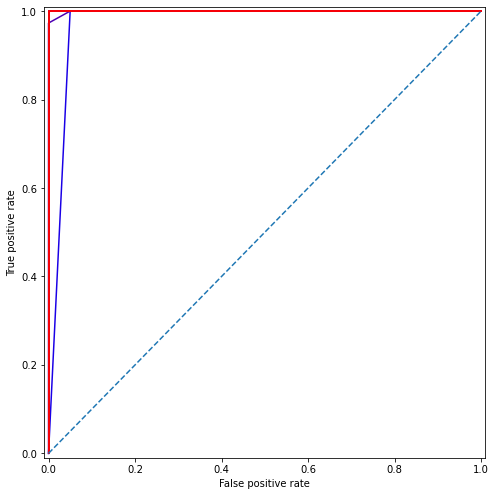

Elapsed time: 4.593106508255005


In [11]:
start = time.time()

X, y = read_cancer_dataset(cancer_dataset_path)
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

print(f"Elapsed time: {time.time() - start}")

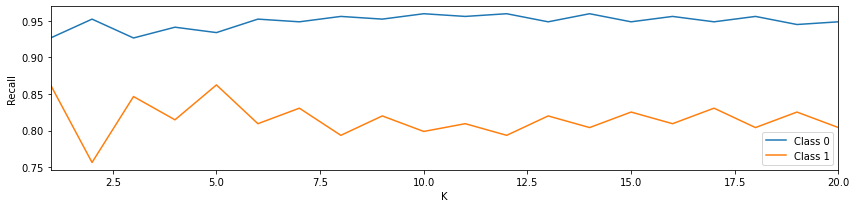

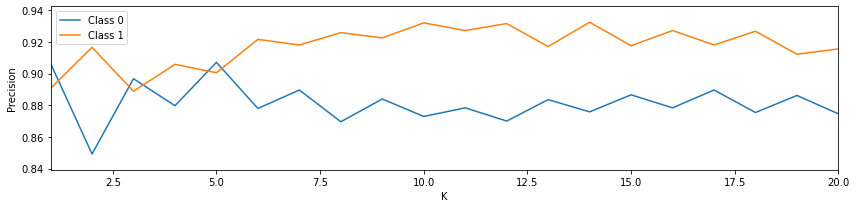

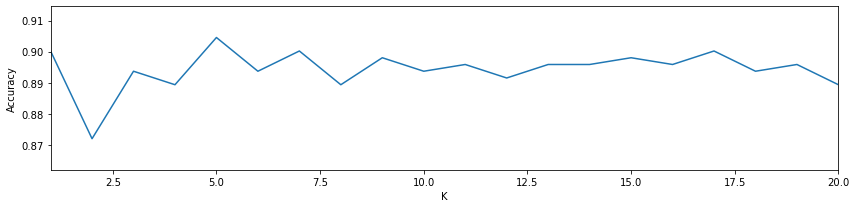

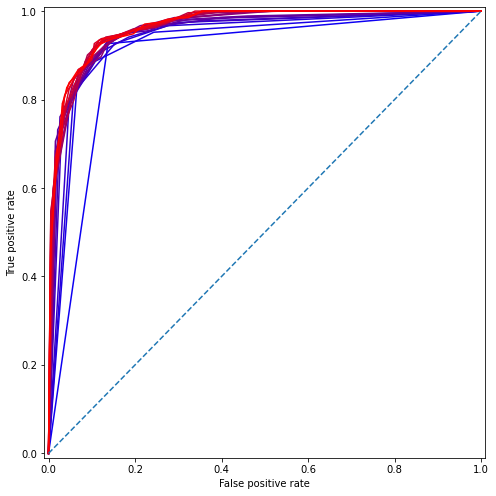

Elapsed time: 209.01531052589417


In [12]:
start = time.time()

X, y = read_spam_dataset(spam_dataset_path)
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)

print(f"Elapsed time: {time.time() - start}")